<a href="https://colab.research.google.com/github/MJWu-wizard/Linux2021Fall/blob/master/MJHW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 48.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 97.9MB/s]


In [11]:
# Porth
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import numpy as np
import csv
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


#定義一個固定亂數
myseed=42066
#torch.backends.cudnn.deterministic是啥？顾名思义，将这个 flag 置为True的话，每次返回的卷积算法将是确定的，即默认算法。如果配合上设置 Torch 的随机种子为固定值的话，应该可以保证每次运行网络的时候相同输入的输出是固定的，代码大致这样

torch.backends.cudnn.deterministic=True


#如果网络的输入数据维度或类型上变化不大，设置 torch.backends.cudnn. benchmark = true 可以增加运行效率； 如果网络的输入数据在每次iteration 都变化的话，会导致cnDNN 每次都会去寻找一遍最优配置，这样反而会降低运行效率。
torch.backends.cudnn.benchmark = False

np.random.seed=(myseed)
torch.manual_seed(myseed)

# torch.cuda.manual_seed()b表示在GPU中设置生成随机数的种子。当设置的种子固定下来的时候，之后依次pytorch生成的随机数序列也被固定下来。torch.cuda.manual_seed_all()则是为所有的GPU设置种子。需要注意的是当只调用torch.cuda.manual_seed()一次时并不能生成相同的随机数序列。如果想要得到相同的随机数序列就需要每次产生随机数的时候都要调用一下torch.cuda.manual_seed()。
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)


In [12]:
#畫圖 Some Utilities
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

Preprocess
We have three kinds of datasets:

train: for training
dev: for validation
test: for testing (w/o target value)

Dataset
The COVID19Dataset below does:

read .csv files
extract features
split covid.train.csv into train/dev sets
normalize features
Finishing TODO below might make you pass medium baseline.

In [13]:
class COVID19Dataset(Dataset):
  ''' Dataset for loading and preprocessing the COVID19 dataset '''
  def __init__(self, path,mode="train",target_only=False):
    self.mode=mode
    #將資料讀到dataset
    with open(path,'r') as fp:
      data=list(csv.reader(fp))
      data=np.array(data[1:])[:,1:].astype(float)
    if not target_only:
      feats=list(range(93))
    else:
      # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
      pass
    if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
    
    else:
      # Training data (train/dev sets)
      # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
      target=data[:,-1]
      data=data[:,feats]          
      
      #切割資料集
      if mode=='train':
        indices=[i for i in range(len(data)) if i%10 !=0]
      elif mode=='dev':
        indices = [i for i in range(len(data)) if i % 10 == 0]
      # Convert data into PyTorch tensors
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])
    # 正規化 Normalize features (you may remove this part to see what will happen)
    self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)
    self.dim = self.data.shape[1]

    print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    
  def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

  def __len__(self):
        # Returns the size of the dataset
        return len(self.data)
    
      


In [14]:
# DataLoader
def prep_dataloader(path,mode,batch_size,n_jobs=0,target_only=False):
  ''' Generates a dataset, then is put into a dataloader. '''
  dataset=COVID19Dataset(path,mode=mode,target_only=target_only)
  dataloader=DataLoader(dataset,batch_size,shuffle=(mode=='train'),drop_last=False,num_workers=n_jobs,pin_memory=True)
  return dataloader
  

In [25]:
# Deep NeuWork
class NeuralNet(nn.Module):
  def __init__(self,input_dim):
    super(NeuralNet,self).__init__()
    #定義網路

    self.net=nn.Sequential(
        nn.Linear(input_dim,64),
        nn.ReLU(),
        nn.Linear(64,1)

     )
    #MSE LOSS
    #reduction (string, optional) – Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'. 'none': no reduction will be applied, 'mean': the sum of the output will be divided by the number of elements in the output, 'sum': the output will be summed. Note: size_average and reduce are in the process of being deprecated, and in the meantime, specifying either of those two args will override reduction. Default: 'mean'
    self.criterion =nn.MSELoss(reduction='mean')

  def forward(self,x):
    return self.net(x).squeeze(1)
  def cal_loss(self,pred,target):
    # TODO: you may implement L1/L2 regularization here
    return self.criterion(pred, target)

Training

In [29]:
def train(tr_set,dv_set,model,config,device):
  n_epochs=config['n_epochs']
  #優化器
  optimizer=getattr(torch.optim,config['optimizer'])(model.parameters(),**config['optim_hparas'])
  min_mse = 1000.
  loss_record = {'train': [], 'dev': []}      # for recording training loss
  early_stop_cnt = 0
  epoch = 0

  while epoch<n_epochs:
    model.train()
    for x,y in tr_set:
      optimizer.zero_grad()
      x,y=x.to(device),y.to(device)
      pred=model(x)
      mse_loss=model.cal_loss(pred,y)
      mse_loss.backward()
      optimizer.step()
      loss_record['train'].append(mse_loss.detach().cpu().item())
    # After each epoch, test your model on the validation (development) set.
    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      # Save model if your model improved
      min_mse = dev_mse
      print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_mse))
      torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1

    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
      break

  print('Finished training after {} epochs'.format(epoch))
  return min_mse, loss_record

validation

In [17]:
def dev(dv_set, model, device):
  model.eval()
  total_loss=0
  for x,y in dv_set:
    x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
    with torch.no_grad():                   # disable gradient calculation
        pred = model(x)                     # forward pass (compute output)
        mse_loss = model.cal_loss(pred, y)  # compute loss
    total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
  total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

  return total_loss

test

In [18]:
def test(tt_set, model, device):
  model.eval()
  preds=[]
  for x in tt_set:
    x = x.to(device) 
    with torch.no_grad():
      pred=model(x)
      preds.append(pred.detach().cpu())
  preds=torch.cat(pred,dim=0).numpy()
  return preds

config

In [19]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

Load data and model

In [30]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [31]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [32]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 111.6376)
Saving model (epoch =    2, loss = 43.1551)
Saving model (epoch =    3, loss = 27.8899)
Saving model (epoch =    4, loss = 16.3109)
Saving model (epoch =    5, loss = 9.8320)
Saving model (epoch =    6, loss = 7.2141)
Saving model (epoch =    7, loss = 5.8035)
Saving model (epoch =    8, loss = 4.9565)
Saving model (epoch =    9, loss = 4.4091)
Saving model (epoch =   10, loss = 3.9233)
Saving model (epoch =   11, loss = 3.5132)
Saving model (epoch =   12, loss = 3.2175)
Saving model (epoch =   13, loss = 2.9891)
Saving model (epoch =   14, loss = 2.7618)
Saving model (epoch =   15, loss = 2.5970)
Saving model (epoch =   16, loss = 2.4237)
Saving model (epoch =   17, loss = 2.3017)
Saving model (epoch =   18, loss = 2.1618)
Saving model (epoch =   19, loss = 2.1045)
Saving model (epoch =   20, loss = 2.0006)
Saving model (epoch =   21, loss = 1.9219)
Saving model (epoch =   22, loss = 1.8537)
Saving model (epoch =   23, loss = 1.7651)
Saving

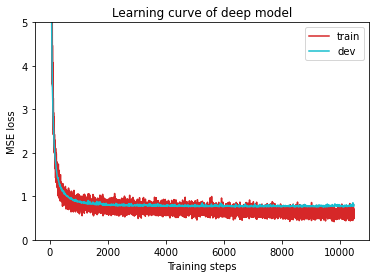

In [33]:
plot_learning_curve(model_loss_record, title='deep model')

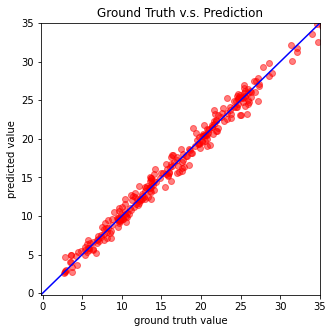

In [34]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

Testing

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv